In [3]:
import pandas as pd

In [4]:
#Leo el csv de eventos

events_df = pd.read_csv("/home/miki_mustard/Desktop/Facultad/Datos/TP2/fiuba-trocafone-tp2-final-set/events_up_to_01062018.csv", low_memory=False)

In [5]:
events_df.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
features_df = pd.DataFrame()

In [6]:
features_df['person'] = events_df.person.unique()

In [34]:
len(events_df.person.unique())

38829

In [7]:
features_df.head()

,person
0,4886f805
1,ad93850f
2,0297fc1e
3,2d681dd8
4,cccea85e


In [8]:
df = events_df.groupby('person').event.count()

In [9]:
features_df = features_df.join(df, on='person')

In [10]:
features_df.rename(columns={'event':'cant_eventos_totales'}, inplace=True)

In [11]:
features_df.head()

,person,cant_eventos_totales
0,4886f805,9
1,ad93850f,65
2,0297fc1e,567
3,2d681dd8,26
4,cccea85e,836


In [12]:
df = events_df.groupby('person').event.value_counts()

In [13]:
df = df.unstack()
df

event,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
person,,,,,,,,,,,
0008ed71,NaN,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0
00091926,15.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,372.0,34.0
00091a7a,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0
000ba417,1.0,24.0,6.0,1.0,14.0,NaN,1.0,NaN,NaN,153.0,6.0
000c79fe,1.0,NaN,1.0,NaN,1.0,NaN,1.0,9.0,NaN,3.0,1.0
000e4d9e,19.0,17.0,1.0,NaN,17.0,NaN,5.0,NaN,NaN,339.0,13.0
000e619d,6.0,11.0,1.0,NaN,8.0,NaN,3.0,6.0,NaN,28.0,5.0
001001be,NaN,NaN,3.0,1.0,3.0,NaN,NaN,17.0,NaN,41.0,3.0
0010e89a,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [14]:
features_df = features_df.join(df, on='person')

In [15]:
features_df.head()

,person,cant_eventos_totales,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
0,4886f805,9,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,4.0,1.0
1,ad93850f,65,10.0,15.0,1.0,NaN,7.0,NaN,7.0,NaN,NaN,20.0,5.0
2,0297fc1e,567,29.0,4.0,7.0,NaN,21.0,1.0,NaN,6.0,NaN,404.0,95.0
3,2d681dd8,26,1.0,5.0,1.0,NaN,1.0,NaN,2.0,1.0,NaN,13.0,2.0
4,cccea85e,836,15.0,7.0,1.0,NaN,20.0,NaN,26.0,1.0,5.0,739.0,22.0


In [16]:
features_df.rename(columns={'ad campign hit':'cant_ach', 'brand listing':'cant_bl', 'checkout':'cant_ch', 
                            'conversion':'cant_cv', 'generic listing':'cant_gl', 'lead':'cant_l',
                           'search engine hit':'cant_seh', 'searched products':'cant_s_p', 
                            'staticpage':'cant_sp', 'viewed product':'cant_vp', 'visited site':'cant_vs'}, inplace=True)

In [17]:
features_df.head()

,person,cant_eventos_totales,ad campaign hit,cant_bl,cant_ch,cant_cv,cant_gl,cant_l,cant_seh,cant_s_p,cant_sp,cant_vp,cant_vs
0,4886f805,9,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,4.0,1.0
1,ad93850f,65,10.0,15.0,1.0,NaN,7.0,NaN,7.0,NaN,NaN,20.0,5.0
2,0297fc1e,567,29.0,4.0,7.0,NaN,21.0,1.0,NaN,6.0,NaN,404.0,95.0
3,2d681dd8,26,1.0,5.0,1.0,NaN,1.0,NaN,2.0,1.0,NaN,13.0,2.0
4,cccea85e,836,15.0,7.0,1.0,NaN,20.0,NaN,26.0,1.0,5.0,739.0,22.0


In [18]:
features_df.fillna(0, inplace=True)

In [19]:
features_df.head()

,person,cant_eventos_totales,ad campaign hit,cant_bl,cant_ch,cant_cv,cant_gl,cant_l,cant_seh,cant_s_p,cant_sp,cant_vp,cant_vs
0,4886f805,9,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,1.0
1,ad93850f,65,10.0,15.0,1.0,0.0,7.0,0.0,7.0,0.0,0.0,20.0,5.0
2,0297fc1e,567,29.0,4.0,7.0,0.0,21.0,1.0,0.0,6.0,0.0,404.0,95.0
3,2d681dd8,26,1.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,13.0,2.0
4,cccea85e,836,15.0,7.0,1.0,0.0,20.0,0.0,26.0,1.0,5.0,739.0,22.0


In [20]:
df = events_df.groupby('person').new_vs_returning.value_counts().unstack().drop(columns=['New'])

In [21]:
features_df = features_df.join(df, on='person')

In [22]:
features_df.head()

,person,cant_eventos_totales,ad campaign hit,cant_bl,cant_ch,cant_cv,cant_gl,cant_l,cant_seh,cant_s_p,cant_sp,cant_vp,cant_vs,Returning
0,4886f805,9,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,1.0,NaN
1,ad93850f,65,10.0,15.0,1.0,0.0,7.0,0.0,7.0,0.0,0.0,20.0,5.0,4.0
2,0297fc1e,567,29.0,4.0,7.0,0.0,21.0,1.0,0.0,6.0,0.0,404.0,95.0,94.0
3,2d681dd8,26,1.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,13.0,2.0,1.0
4,cccea85e,836,15.0,7.0,1.0,0.0,20.0,0.0,26.0,1.0,5.0,739.0,22.0,21.0


In [ ]:
#Quincenas

#Acomodar
#events['q1'] = ((events['mes']==1) & (events['dia']>1) & (events['dia']<16))
#events['q2'] = ((events['mes']==1) & (events['dia']>15) & (events['dia']<32))
#events['q3'] = ((events['mes']==2) & (events['dia']>1) & (events['dia']<16))
#events['q4'] = ((events['mes']==2) & (events['dia']>15) & (events['dia']<29))
#events['q5'] = ((events['mes']==3) & (events['dia']>1) & (events['dia']<16))
#events['q6'] = ((events['mes']==3) & (events['dia']>15) & (events['dia']<32))
#events['q7'] = ((events['mes']==4) & (events['dia']>1) & (events['dia']<16))
#events['q8'] = ((events['mes']==4) & (events['dia']>15) & (events['dia']<31))
#events['q9'] = ((events['mes']==5) & (events['dia']>1) & (events['dia']<16))
#events['q10'] = ((events['mes']==5) & (events['dia']>15) & (events['dia']<32))

## Support storage

In [23]:
#Mas features
st = pd.crosstab(events_df.person, events_df.storage)

In [35]:
st.shape
#No se por que tiene menos personas que features_df, ver!!!

(38250, 8)

In [24]:
st = st.astype('bool')

In [25]:
from mlxtend.frequent_patterns import apriori 
frequent_itemsets = apriori(st, min_support=0.0, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head()

,support,itemsets,length
0,0.299320,(128GB),1
1,0.693281,(16GB),1
2,0.116706,(256GB),1
3,0.629935,(32GB),1
4,0.044261,(4GB),1


In [26]:
def columna_por_persona(crosstab):
    diccionario = {}
    for person in crosstab.index :
        #print(person)
        lista_value = list()
        for value in crosstab.columns :
            if crosstab.loc[person, value] > 0 :
                lista_value.append(value)
        values = frozenset(lista_value)        
        diccionario[person] = values                
    return diccionario

In [27]:
result_spp = columna_por_persona(st)

In [28]:
#Algoritmo para asignarle el support a la persona segun sus eventos(Toma todos los ev realizados por la persona)
#Result es lo que devuelve storage por persona
def asignar_support(result, frequent_itemsets):
    lista_support = list()
    for value in result.values() :
        #print(value)
        support_value = obtener_support(value, frequent_itemsets)
        #print(support_value)
        lista_support.append(support_value)
    return lista_support    
    

In [29]:
def obtener_support(nupla, frequent_itemsets):
    if( len(frequent_itemsets.loc[ frequent_itemsets['itemsets']==nupla ].support.values) == 0 ):
        return 0;
    support_value = frequent_itemsets.loc[ frequent_itemsets['itemsets']==nupla ].support.values[0]
    return support_value   

In [31]:
lista_support = asignar_support(result_spp, frequent_itemsets)
len(lista_support)

38250

In [30]:
def lista_personas_f(result):
    lista_personas = list()
    for key in result.keys():
        lista_personas.append(key)
    return lista_personas

In [32]:
lista_personas = lista_personas_f(result_spp)
len(lista_personas)

38250

In [36]:
d = {'person': lista_personas, 'storage_support': lista_support}
df = pd.DataFrame(data=d)

In [38]:
features_df = features_df.join(df.set_index('person'), on='person')

In [39]:
features_df.head()

,person,cant_eventos_totales,ad campaign hit,cant_bl,cant_ch,cant_cv,cant_gl,cant_l,cant_seh,cant_s_p,cant_sp,cant_vp,cant_vs,Returning,storage_support
0,4886f805,9,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,1.0,NaN,0.629935
1,ad93850f,65,10.0,15.0,1.0,0.0,7.0,0.0,7.0,0.0,0.0,20.0,5.0,4.0,0.192209
2,0297fc1e,567,29.0,4.0,7.0,0.0,21.0,1.0,0.0,6.0,0.0,404.0,95.0,94.0,0.073778
3,2d681dd8,26,1.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,13.0,2.0,1.0,0.209882
4,cccea85e,836,15.0,7.0,1.0,0.0,20.0,0.0,26.0,1.0,5.0,739.0,22.0,21.0,0.134850


## Support eventos

In [64]:
#Primero teniendo en cuenta todos los eventos realizados por la persona
ct = pd.crosstab(events_df.person, events_df.event)

In [65]:
ct = ct.astype('bool')

In [66]:
frequent_itemsets = apriori(ct, min_support=0.0, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head()

,support,itemsets,length
0,0.821551,(ad campaign hit),1
1,0.495223,(brand listing),1
2,0.845579,(checkout),1
3,0.110562,(conversion),1
4,0.648613,(generic listing),1


In [67]:
result = columna_por_persona(ct)

In [68]:
lista_support = asignar_support(result, frequent_itemsets)
len(lista_support)

38829

In [69]:
lista_personas = lista_personas_f(result)
len(lista_personas)

38829

In [72]:
d = {'person': lista_personas, 'event_support': lista_support}
df = pd.DataFrame(data=d)

In [73]:
features_df = features_df.join(df.set_index('person'), on='person')

In [74]:
features_df.head()

,person,cant_eventos_totales,ad campaign hit,cant_bl,cant_ch,cant_cv,cant_gl,cant_l,cant_seh,cant_s_p,cant_sp,cant_vp,cant_vs,Returning,storage_support,event_support
0,4886f805,9,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,1.0,NaN,0.629935,0.218522
1,ad93850f,65,10.0,15.0,1.0,0.0,7.0,0.0,7.0,0.0,0.0,20.0,5.0,4.0,0.192209,0.260913
2,0297fc1e,567,29.0,4.0,7.0,0.0,21.0,1.0,0.0,6.0,0.0,404.0,95.0,94.0,0.073778,0.008396
3,2d681dd8,26,1.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,13.0,2.0,1.0,0.209882,0.138376
4,cccea85e,836,15.0,7.0,1.0,0.0,20.0,0.0,26.0,1.0,5.0,739.0,22.0,21.0,0.134850,0.038811


In [40]:
import xgboost as xgb

In [41]:
labels_df = pd.read_csv("/home/miki_mustard/Desktop/Facultad/Datos/TP2/fiuba-trocafone-tp2-final-set/labels_training_set.csv", low_memory=False)

In [75]:
train_df = features_df.merge(labels_df, on='person', how='right')
train_df.shape

(19414, 17)

In [76]:
labels = train_df.label
train_df = train_df.drop(columns=['label'])

In [77]:
to_predict = features_df[~features_df.person.isin(labels_df.person)]
to_predict.shape

(19415, 16)

In [78]:
data_dmatrix = xgb.DMatrix(data=train_df.drop(columns=['person']) , label=labels)

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(train_df.drop(columns=['person']) , labels, test_size=0.2, random_state=123)

In [80]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic',base_score= 0.1, 
                          colsample_bylevel= 0.9, booster='dart', 
                colsample_bytree = 0.5, learning_rate = 0.2,
                max_depth = 8, alpha = 20, gamma=10, n_estimators = 35, eval_metric='auc')

In [81]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=20, base_score=0.1, booster='dart', colsample_bylevel=0.9,
       colsample_bytree=0.5, eval_metric='auc', gamma=10,
       learning_rate=0.2, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=35, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [82]:
preds = xg_reg.predict(X_test)

In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,preds)

0.8101947742544024

In [84]:
preds_posta = xg_reg.predict(to_predict.drop(columns=['person']))

In [85]:
preds_posta

array([0.01125816, 0.07129408, 0.02125723, ..., 0.13428943, 0.13428943,
       0.13428943], dtype=float32)

In [86]:
to_publish = pd.DataFrame()

In [87]:
to_publish['person'] = to_predict.person
to_publish.shape

(19415, 1)

In [88]:
to_publish['label'] = preds_posta
to_publish.shape

(19415, 2)

In [89]:
to_publish.head()

,person,label
0,4886f805,0.011258
2,0297fc1e,0.071294
3,2d681dd8,0.021257
4,cccea85e,0.063101
5,4c8a8b93,0.076077


In [90]:
to_publish.to_csv('27_11_4_con_ss.csv', index=False)

In [91]:
to_publish.loc[ to_publish.label < 0 ]

,person,label


In [92]:
params = {'objective':'binary:logistic', 'base_score':'0.3', 
                      'colsample_bylevel':'0.7', 'booster':'dart', 
                      'colsample_bytree':'0.4', 'learning_rate':'0.25',
                      'max_depth':'13', 'alpha':'25', 'gamma':'10', 
                      'n_estimators':'23', 'eval_metric':'auc'}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123)

[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_p

[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[20:21:40] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:40] /workspace/src/tree/updater_p

[20:21:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[20:21:41] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[20:21:41] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[20:21:41] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[20:21:41] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[20:21:41] /workspace/src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[20:21:41] /workspace/src/tree/updater_p

In [93]:
cv_results.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.704713,0.007337,0.703751,0.015542
1,0.704713,0.007337,0.703751,0.015542
2,0.704713,0.007337,0.703751,0.015542
3,0.722770,0.031667,0.717449,0.010355
4,0.733336,0.029556,0.729165,0.006410


AttributeError: module 'matplotlib' has no attribute 'show'

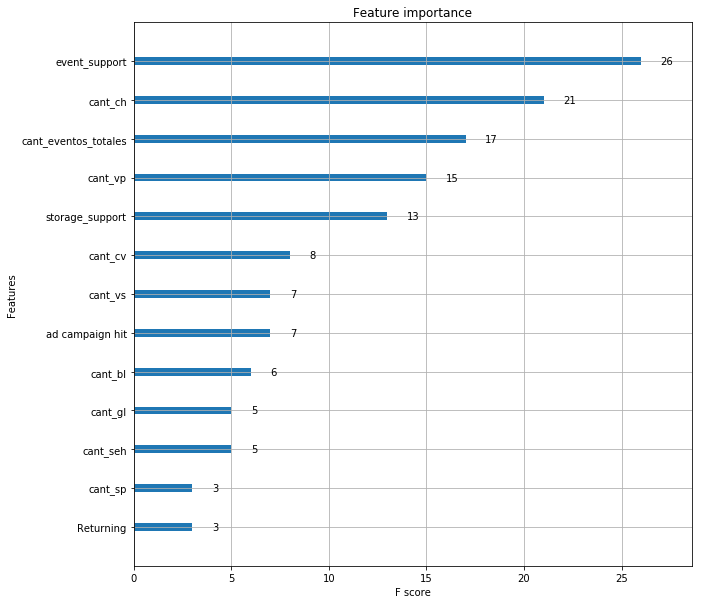

In [94]:
import matplotlib as plt

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()